# Analyzing Open Jobs in NYC City Government

NYC Open Data has released a list of all the open jobs in the city of New York. I downloaded the data in CSV form [here](https://data.cityofnewyork.us/Business/NYC-Jobs/kpav-sd4t).

My goal is to answer the following questions:

1. Who has the most openings?
2. Which departments have the highest and the lowest paying positions (based on current job openings)?
3. Which jobs do you think are the hardest to fill? (What makes you say that?)

Some info to consider that isn't immediately apparent from the dataset at first glance:
* Some rows of job listings represent more than one available position with that job title. This is indicated anytime the column "# Of Positions" is > 1. This is important for calculating the answer to question 1.
* Some rows of job listings have exactly the same Job ID and information, except that one has a Posting Type of Internal and the other External. We should not count these as two separate positions when answering the first two questions, since they technically represent the same job opening that was posted to two different outlets.
* The column "Salary Frequency" can be Hourly, Daily or Annual. This should be factored into our investigation of question 2.

OK, let's get started!

In [1]:
%matplotlib inline 

import math
import pandas as pd
import numpy as np
import csv
import json
import matplotlib.pyplot as plt
from collections import defaultdict


nyc_jobs = pd.read_csv('NYC_Jobs.csv', encoding='utf-8')
nyc_jobs.columns = ['Job ID','Agency','Posting Type','# Of Positions','Business Title','Civil Service Title','Title Code No',
'Level','Salary Range From','Salary Range To','Salary Frequency','Work Location','Division/Work Unit','Job Description',
'Minimum Qual Requirements','Preferred Skills','Additional Information','To Apply','Hours/Shift','Work Location 1','Recruitment Contact',
'Residency Requirement','Posting Date','Post Until','Posting Updated','Process Date']

Let's test it out by printing out the first 3 rows.

In [2]:
nyc_jobs[:3]
#check data types of each column
#nyc_jobs.dtypes

,Job ID,Agency,Posting Type,# Of Positions,Business Title,Civil Service Title,Title Code No,Level,Salary Range From,Salary Range To,...,Additional Information,To Apply,Hours/Shift,Work Location 1,Recruitment Contact,Residency Requirement,Posting Date,Post Until,Posting Updated,Process Date
0,167179,NYC EMPLOYEES RETIREMENT SYS,Internal,1,"CERTIFIED IT ADMINISTRATOR (WAN), Level 4",CERT. IT ADMINISTRATOR WAN,13642,04,87203,131623,...,,To apply please click the ''apply now'' button...,,,NaN,New York City Residency is not required for th...,11/19/2014 00:00:00,NaN,11/19/2014 00:00:00,02/23/2016 00:00:00
1,167179,NYC EMPLOYEES RETIREMENT SYS,External,1,"CERTIFIED IT ADMINISTRATOR (WAN), Level 4",CERT. IT ADMINISTRATOR WAN,13642,04,87203,131623,...,,To apply please click the ''apply now'' button...,,,NaN,New York City Residency is not required for th...,11/19/2014 00:00:00,NaN,11/19/2014 00:00:00,02/23/2016 00:00:00
2,168165,DEPT OF HEALTH/MENTAL HYGIENE,External,1,"Project Coordinator, District Public Health Br...",ADMINISTRATIVE STAFF ANALYST (,1002A,00,56937,88649,...,,Apply online with a cover letter to https://a1...,,"485 Throop Avenue, Brooklyn, NY, 11221",NaN,New York City residency is generally required ...,09/18/2014 00:00:00,NaN,09/18/2014 00:00:00,02/23/2016 00:00:00


Notice something interesting about the above? Rows 0 and 1 are the exact same listing (Job ID is the same). The only difference is that one is an internal listing and one is external (see posting type column). We should not count these as 2 separate openings. How do we avoid counting these as two separate postings? 

Let's check if all external postings have already been posted internally.

In [3]:
internal_ids = nyc_jobs[nyc_jobs['Posting Type'] == 'Internal']['Job ID']
external_ids = nyc_jobs[nyc_jobs['Posting Type'] == 'External']['Job ID']

external_only = set(external_ids) - set(internal_ids)
external_only_df = nyc_jobs[nyc_jobs['Job ID'].isin(external_only)]
external_only_df.head()

,Job ID,Agency,Posting Type,# Of Positions,Business Title,Civil Service Title,Title Code No,Level,Salary Range From,Salary Range To,...,Additional Information,To Apply,Hours/Shift,Work Location 1,Recruitment Contact,Residency Requirement,Posting Date,Post Until,Posting Updated,Process Date
35,151131,NYC HOUSING AUTHORITY,External,1,Cost Estimating Manager,ADMINISTRATIVE STAFF ANALYST (,1002D,00,90000,110000,...,SPECIAL INSTRUCTIONS FOR NYCHA EMPLOYEES: N...,Click the ''Apply Now'' button.,,,NaN,NYCHA has no residency requirements.,06/25/2014 00:00:00,NaN,07/07/2014 00:00:00,02/23/2016 00:00:00
119,163183,DEPT OF ENVIRONMENT PROTECTION,External,1,Per Diem - Remote Learning Team Specialist,COMPUTER PROGRAMMER ANALYST,13651,01,24,33,...,,Click the ''apply now'' button.,,59-17 Junction Blvd Corona Ny,NaN,New York City Residency is not required for th...,08/27/2014 00:00:00,NaN,08/27/2014 00:00:00,02/23/2016 00:00:00
1067,209312,DEPARTMENT OF TRANSPORTATION,External,2,Deputy Queens Borough Commissioner - 2 positions,CONFIDENTIAL STRATEGY PLANNER,54738,00,52808,88890,...,MINIMUM QUALIFICATION REQUIREMENTS: A baccalau...,All resumes are to be submitted electronically...,,,NaN,New York City residency is generally required ...,08/26/2015 00:00:00,NaN,09/16/2015 00:00:00,02/23/2016 00:00:00
1500,217474,HOUSING PRESERVATION & DVLPMNT,External,1,Environmental Planner,CITY PLANNER,22122,01,49897,65000,...,,Apply Online,,100 Gold Street,NaN,New York City residency is generally required ...,10/05/2015 00:00:00,NaN,10/05/2015 00:00:00,02/23/2016 00:00:00
3568,231079,HOUSING PRESERVATION & DVLPMNT,External,1,Assistant Architect,ASSISTANT ARCHITECT,21210,00,51586,77404,...,,NaN,,100 Gold Street,NaN,New York City Residency is not required for th...,02/09/2016 00:00:00,NaN,02/09/2016 00:00:00,02/23/2016 00:00:00


Looks like 5 job IDs are posted externally, but not internally. Interesting.

Let's use drop_duplicates('Job ID') to make sure listings that appear twice only appear once in our dataframe.

In [4]:
df2 = nyc_jobs.copy()
#drop columns where value is null
df2 = df2.dropna(axis=1, how='any')

df2 = df2.drop_duplicates('Job ID')
df2.head()

,Job ID,Agency,Posting Type,# Of Positions,Business Title,Civil Service Title,Title Code No,Level,Salary Range From,Salary Range To,...,Division/Work Unit,Job Description,Preferred Skills,Additional Information,Hours/Shift,Work Location 1,Residency Requirement,Posting Date,Posting Updated,Process Date
0,167179,NYC EMPLOYEES RETIREMENT SYS,Internal,1,"CERTIFIED IT ADMINISTRATOR (WAN), Level 4",CERT. IT ADMINISTRATOR WAN,13642,04,87203,131623,...,Executive Management,"Oversees the design, installation, configurati...","Minimum 5 years of experience planning, design...",,,,New York City Residency is not required for th...,11/19/2014 00:00:00,11/19/2014 00:00:00,02/23/2016 00:00:00
2,168165,DEPT OF HEALTH/MENTAL HYGIENE,External,1,"Project Coordinator, District Public Health Br...",ADMINISTRATIVE STAFF ANALYST (,1002A,00,56937,88649,...,District Public Health Brklyn,The Brooklyn District Public Health Office (DP...,Master's degree in public health or equivalent...,,,"485 Throop Avenue, Brooklyn, NY, 11221",New York City residency is generally required ...,09/18/2014 00:00:00,09/18/2014 00:00:00,02/23/2016 00:00:00
3,149599,DEPT OF ENVIRONMENT PROTECTION,External,1,Construction Project Manager Intern,CONSTRUCTION PROJECT MANAGER I,34201,00,43349,52496,...,JOCS- IFA,"Working within Capital Coordination, under dir...",,Appointments are subject to OMB approval. For...,35 Hours per Week,,New York City residency is generally required ...,04/25/2014 00:00:00,04/25/2014 00:00:00,02/23/2016 00:00:00
5,149908,DEPARTMENT OF BUILDINGS,External,3,Senior Application Developer,COMPUTER SYSTEMS MANAGER,10050,M1,49492,100000,...,Information Technology,The NYC Department of Buildings (Ã¢â¬ÅDOBÃ¢â...,Ã¢â¬Â¢7+ years substantive hands-on applicati...,,35 hours (minimum),"280 Broadway, 6th Floor, N.Y.",New York City Residency is not required for th...,04/03/2015 00:00:00,04/03/2015 00:00:00,02/23/2016 00:00:00
7,87990,DEPARTMENT OF BUSINESS SERV.,Internal,1,Account Manager,CONTRACT REVIEWER (OFFICE OF L,40563,01,42405,65485,...,Strategy & Analytics,Division of Economic & Financial Opportunity (...,Ã¢â¬Â¢\tExcellent interpersonal and organizat...,"Salary range for this position is: $42,405 - $...",,,New York City residency is generally required ...,06/24/2011 00:00:00,06/24/2011 00:00:00,02/23/2016 00:00:00


## Which Agency has the Highest Number of Job Openings?

On first glance, the value_counts() method seems to give us the answer quite nicely.

In [5]:
#The below gets agency with highest number of job postings, but doesn't account for postings with # Of Positions > 1; 
#we should include these in the total count
df2['Agency'].value_counts()

DEPT OF HEALTH/MENTAL HYGIENE     630
DEPT OF ENVIRONMENT PROTECTION    217
DEPT OF DESIGN & CONSTRUCTION     134
DEPT OF INFO TECH & TELECOMM      123
ADMIN FOR CHILDREN'S SVCS         100
DEPARTMENT OF BUILDINGS            93
HOUSING PRESERVATION & DVLPMNT     80
DEPARTMENT OF INVESTIGATION        73
DEPARTMENT OF TRANSPORTATION       73
DEPARTMENT OF CORRECTION           61
DEPARTMENT OF SANITATION           53
HRA/DEPT OF SOCIAL SERVICES        49
DEPARTMENT OF FINANCE              47
NYC HOUSING AUTHORITY              32
DEPT OF PARKS & RECREATION         32
FIRE DEPARTMENT                    32
DEPARTMENT OF BUSINESS SERV.       31
ADMIN TRIALS AND HEARINGS          22
DEPT OF CITYWIDE ADMIN SVCS        19
CONSUMER AFFAIRS                   16
LAW DEPARTMENT                     16
TAXI & LIMOUSINE COMMISSION        14
DEPT OF YOUTH & COMM DEV SRVS      14
FINANCIAL INFO SVCS AGENCY         14
DEPT. OF HOMELESS SERVICES         13
DEPARTMENT FOR THE AGING           11
CIVILIAN COM

From the above, it looks like the Department of Health/Mental Hygiene has the most openings. But wait! Remember that sneaky "# Of Postings" column? We have to count those, too, right?

In [6]:
#As shown below, # Of Positions prints anywhere from 1 to 100
print df2['# Of Positions'].unique()
#[  1   3   5  52   4   2  50  11  30   6   8  15  10  12  20  16   9   7
#  25  69  75  67  14  17  71  13 100 107  39  18  28]

[  1   3   5  52   4   2  50  11  30   6   8  15  10  12  20  16   9   7
  25  69  75  67  14  17  71  13 100 107  39  18  28]


The unique() method has revealed that "# Of Positions" can be anywhere from 1 to 107. Let's make sure we count the rows with "# Of Positions > 1" as the true number of postings they represent.

In [7]:
by_agency = df2.groupby('Agency')
by_agency['# Of Positions'].sum().sort_values(ascending=False)

Agency
DEPT OF HEALTH/MENTAL HYGIENE     1382
DEPT OF DESIGN & CONSTRUCTION      598
DEPARTMENT OF BUILDINGS            484
DEPT OF ENVIRONMENT PROTECTION     360
ADMIN FOR CHILDREN'S SVCS          275
DEPT OF PARKS & RECREATION         200
NYC HOUSING AUTHORITY              185
DEPARTMENT OF TRANSPORTATION       182
DEPARTMENT OF CORRECTION           178
DEPT OF INFO TECH & TELECOMM       162
DEPARTMENT OF INVESTIGATION        122
HOUSING PRESERVATION & DVLPMNT     114
DEPARTMENT OF SANITATION            73
DEPARTMENT OF FINANCE               56
HRA/DEPT OF SOCIAL SERVICES         53
FIRE DEPARTMENT                     44
ADMIN TRIALS AND HEARINGS           42
DEPARTMENT OF BUSINESS SERV.        42
LAW DEPARTMENT                      30
DEPT OF CITYWIDE ADMIN SVCS         29
DEPT. OF HOMELESS SERVICES          24
TAXI & LIMOUSINE COMMISSION         24
CIVILIAN COMPLAINT REVIEW BD        21
OFFICE OF MANAGEMENT & BUDGET       21
DEPT OF YOUTH & COMM DEV SRVS       19
CONSUMER AFFAIRS  

Looks like the Department of Health/Mental Hygiene still has the most openings, but now that we've removed duplicate postings and counted # of positions, it tells us that it has 1382 instead of 1247 openings. Let's pretend for a second that we didn't have pandas. Could we figure this out using a function written purely in Python? Yes.

In [8]:
#function below creates a dictionary in which the key is the agency and the value is the number of total openings, 
#equivalent to the pandas method above
def count_jobs(data_frame):
    jobs_per_agency = defaultdict(int)
    for i, row in data_frame.iterrows():
        jobs_per_agency[row['Agency']] += int(row['# Of Positions'])
    return jobs_per_agency

print count_jobs(df2)

defaultdict(<type 'int'>, {u'TAXI & LIMOUSINE COMMISSION': 24, u'DEPT OF RECORDS & INFO SERVICE': 10, u'DEPT OF YOUTH & COMM DEV SRVS': 19, u'DISTRICT ATTORNEY RICHMOND COU': 1, u'FINANCIAL INFO SVCS AGENCY': 15, u'NYC HOUSING AUTHORITY': 185, u'HOUSING PRESERVATION & DVLPMNT': 114, u'DEPARTMENT OF TRANSPORTATION': 182, u'DEPARTMENT OF CITY PLANNING': 5, u'ADMIN TRIALS AND HEARINGS': 42, u'DEPARTMENT OF INVESTIGATION': 122, u'CONFLICTS OF INTEREST BOARD': 2, u'DEPT OF PARKS & RECREATION': 200, u'DEPARTMENT OF SANITATION': 73, u'OFFICE OF THE COMPTROLLER': 9, u'DEPT OF CITYWIDE ADMIN SVCS': 29, u'HUMAN RIGHTS COMMISSION': 9, u'CONSUMER AFFAIRS': 17, u'DEPT. OF HOMELESS SERVICES': 24, u'PRESIDENT BOROUGH OF MANHATTAN': 1, u'DEPARTMENT OF CORRECTION': 178, u'NYC EMPLOYEES RETIREMENT SYS': 14, u'DEPT OF INFO TECH & TELECOMM': 162, u'OFFICE OF EMERGENCY MANAGEMENT': 5, u'DEPARTMENT FOR THE AGING': 11, u'DEPARTMENT OF PROBATION': 1, u'DISTRICT ATTORNEY KINGS COUNTY': 3, u'HRA/DEPT OF SOCIAL 

Our function created a dictionary with agency names as the keys and # of Postings as the values. The key Department of Health/Mental Hygiene has a value of 1382, which matches what we found using Pandas.

Now let's dig into that salary information.

## Salary Info

Let's analyze annual salaries first.

In [15]:
# Which agency offers the highest mean salaries? Calculate separately for hourly, daily & annual jobs

#Check that Salary ranges are integers, not NaN values
# nyc_jobs['Salary Range From'].unique() 
# nyc_jobs['Salary Range To'].unique()
#df_annual = df2.copy()

#Remember, we already removed duplicate Job IDs from our df2 dataframe, so we want to make a copy of that one rather than the original, nyc_jobs.

def calculate_salaries(frequency):
    df_by_freq = df2.copy()
    df_jobs = df_by_freq[df_by_freq['Salary Frequency'] == frequency]
    df_jobs.loc[:,'Mean Salary'] = df_jobs.loc[:,['Salary Range From', 'Salary Range To']].mean(axis=1)
    by_agency = df_jobs.groupby('Agency')
    df_jobs.loc[:,'Total Job Budget'] = df_jobs.apply(lambda row: row['Mean Salary'] * row['# Of Positions'], axis=1)
    df_ranks = by_agency.apply(lambda row: row['Total Job Budget'].sum() / row['# Of Positions'].sum())
    num_positions = df_jobs.groupby('Agency')['# Of Positions'].sum()
    df_jobs.loc[:,'Diff From Mean'] = df_jobs.apply(lambda row: ((row['Mean Salary'] - df_ranks[row['Agency']])**2)*row['# Of Positions'], axis=1)
    df_result = df_jobs.groupby('Agency').sum()
    df_result['std dev'] = df_result.apply(lambda row: math.sqrt(row['Diff From Mean']/(row['# Of Positions']-1)), axis=1)
    final_result = pd.concat([df_ranks, num_positions, df_result['std dev']], axis=1)
    final_result.columns = ['Mean Salary', '# Openings', 'Standard Deviaion']
    return final_result.sort_values(by='Mean Salary', ascending=False)
print calculate_salaries('Annual')

                                  Mean Salary  # Openings  Standard Deviaion
Agency                                                                      
OFFICE OF MANAGEMENT & BUDGET   106475.000000           1                NaN
DEPARTMENT OF SANITATION        103411.015152          66       21783.378492
NYC EMPLOYEES RETIREMENT SYS    103281.000000           3       13061.756783
NYC POLICE PENSION FUND          99521.000000           1                NaN
FINANCIAL INFO SVCS AGENCY       90648.000000          15       29441.481947
FIRE DEPARTMENT                  87550.948276          29       17875.159319
DEPARTMENT OF BUSINESS SERV.     85048.200000          35       37432.859672
OFFICE OF THE COMPTROLLER        83960.388889           9       28711.090221
DEPT OF INFO TECH & TELECOMM     83784.474684         158       20756.727264
CONFLICTS OF INTEREST BOARD      76941.750000           2       43546.817566
DEPARTMENT OF CORRECTION         76582.367257         113       32934.290916

Looks like the Office of Management and Budget wins overall, offering an average salary of \$106475. Since we calculated standard deviation by dividing by (n - 1), this resulted in a NaN value for our standard deviation because there was only one opening, so we were dividing by 0. The Department of Sanitation follows closely behind, with an average salary of ~\$103411 and a standard deviation of about ~\$21000. I'm inclined to conclude that the Department of Sanitation consistently offers the highest salaries, since it has a higher number of job openings and a standard deviation that is not especially high when compared to other agencies.

The lowest goes to Cultural Affairs, with an average salary of \$44822. However, since there is only one job opening, it may just be an exception to the other jobs in the agency. Therefore, we are better off concluding that the agency with the lowest pay (based on information from 170 job openings) is the Dept of Parks and Recreation, with a mean salary of ~\$57910.

Let's dig a little more and do the same for hourly and daily salaries.

In [10]:
print calculate_salaries('Hourly') 

                                Mean Salary  # Openings  Standard Deviaion
Agency                                                                    
FIRE DEPARTMENT                   59.750000           2          19.445436
DEPARTMENT FOR THE AGING          39.000000           1                NaN
DEPARTMENT OF CORRECTION          37.000000          22          10.516427
NYC HOUSING AUTHORITY             35.000000          50           0.000000
CIVILIAN COMPLAINT REVIEW BD      34.500000           1                NaN
DEPT OF HEALTH/MENTAL HYGIENE     34.327670         412          12.237339
ADMIN TRIALS AND HEARINGS         34.125000          32          15.219364
LAW DEPARTMENT                    27.500000           4          11.775681
DEPT OF INFO TECH & TELECOMM      26.750000           4          14.722432
DEPT OF RECORDS & INFO SERVICE    26.000000           2           0.707107
DEPARTMENT OF BUSINESS SERV.      22.285714           7           9.647353
DEPT OF ENVIRONMENT PROTE

Looks like the Fire Department pays the highest hourly salaries, at an average rate of \$59.75/hr. The lowest hourly rate goes to the Office of Collective Bargaining, at \$9.50/hr.

Last but not least, let's take a look at salaries for jobs that pay a day rate!

In [11]:
print calculate_salaries('Daily')

                              Mean Salary  # Openings  Standard Deviaion
Agency                                                                  
FIRE DEPARTMENT                321.615385          13          23.020058
DEPARTMENT OF CORRECTION       308.534884          43          91.376406
DEPARTMENT OF TRANSPORTATION   297.500000          13          20.894577
DEPARTMENT OF SANITATION       287.750000           6           7.960842
DEPT OF CITYWIDE ADMIN SVCS    271.444444           9          40.568187


The Fire Department wins again, with a ~\$321 day rate (that comes out to a six figure annual salary if you assume you work at least 311 days). The Department of Correction is not far behind, offering a salary of ~\$308/day. Crime pays (as long as you're the one holding the keys)!

### Conclusion

From our analysis of current job openings, it looks like the __Department of Sanitation__ offers potential candidates the highest __annual salaries__ when you factor in the number of annual openings, whereas the __Fire Department__ offers the highest __hourly and daily salaries.__

Just for fun, let's plot the breakdown of job postings with Daily, Hourly and Annual salaries.

There are 84 jobs with a daily pay rate.
There are 4078 jobs offering an annual salary.
There are 676 jobs with hourly pay rate.


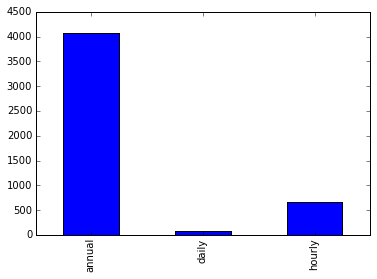

In [12]:
#remember that df2 is our dataframe with duplicate Job IDs removed.

daily_jobs = df2[df2['Salary Frequency']=='Daily']
total_daily = daily_jobs['# Of Positions'].sum()
print "There are", total_daily, "jobs with a daily pay rate."

annual_jobs = df2[df2['Salary Frequency'] == 'Annual']
total_annual = annual_jobs['# Of Positions'].sum()
print "There are", total_annual, "jobs offering an annual salary."

hourly_jobs = df2[df2['Salary Frequency'] == 'Hourly']
total_hourly = hourly_jobs['# Of Positions'].sum()
print "There are", total_hourly, "jobs with hourly pay rate."

job_type_dict = dict()
job_type_dict['daily'] = total_daily
job_type_dict['annual'] = total_annual
job_type_dict['hourly'] = total_hourly

job_type = pd.Series(job_type_dict)

%matplotlib inline

job_type.plot(kind="bar")

## Which jobs are the hardest to fill?

A few things come to mind. Remember that the columms tell us the information available to us: ['Job ID','Agency','Posting Type','# Of Positions','Business Title','Civil Service Title','Title Code No','Level','Salary Range From','Salary Range To','Salary Frequency','Work Location','Division/Work Unit','Job Description','Minimum Qual Requirements','Preferred Skills','Additional Information','To Apply','Hours/Shift','Work Location 1','Recruitment Contact','Residency Requirement','Posting Date','Post Until','Posting Updated','Process Date']

Areas to investigate:
* __Which jobs have been posted for the longest amount of time?__ Our data source says that the dataset contains **current** job postings. Therefore, we can assume that if a job listing is included in the dataset, it has not yet been filled. My initial thought is that the older a job listing is, the harder it is to fill the position. But there is always the possibility that an agency just forgot to remove the job from the database after the job was filled.
* __Which jobs have the lowest salaries? What about the highest salaries?__ It's tough to attract job talent when you're offering a low salary, especially in NYC, where the cost of living is so high. Low salaries could prevent qualified people from applying. High salaries, on the other hand, could also be hard to fill. Perhaps a salary is high out of necessity: because a job is so demanding and unappealing. Alternatively, a high salary may indicate that the position requires more specialized knowledge and will compensate accordingly for that knowledge.
* __Which jobs have the most "# Of Positions" to fill?__ I'm guessing that the more # of positions available, the harder it must be to fill a particular job.
* __Which jobs have the lengthiest "Minimum Qual Requirements" or "Preferred Skills" fields?__ Perhaps the longer these fields are, the more difficult it is to fill the position because people don't feel qualified for the position, or the hiring manager has higher standards for this position.

We will focus on the oldest job listings because that seems to be an objective indication of how tough a job is to fill. For instance, low salaries may attract more candidates because they require less experience. But it's a little harder to argue that a job that has remained on the database is getting inundated with job applications, because if the job was really attractive, you would think that the agency would take the time to remove the job so that they wouldn't get so many applications. The fact that these postings have not been removed yet indicates that they have been seeking applicants for a long time, and will continue to do so until the position(s) is/are filled.

## The oldest listings
Let's convert the Posting Date column to a data type of datetime by using pd.to_datetime()!



In [13]:
df2['Posting Date'] = pd.to_datetime(df2['Posting Date'])
oldest_jobs = df2.sort_values('Posting Date', ascending=True)

oldest_jobs = oldest_jobs.loc[:,['Agency', 'Business Title', '# Of Positions', 'Posting Date']]

from datetime import datetime

def time_elapsed(post_date):
    today = datetime.today()
    diff = today - post_date
    return diff.days

#apply this function to your pandas dataframe
oldest_jobs['Days Elapsed'] = oldest_jobs['Posting Date'].apply(time_elapsed)

print "Average number of days elapsed since Posting Date: ", oldest_jobs['Days Elapsed'].mean()

Average number of days elapsed since Posting Date:  170.322066634


In [14]:
oldest_jobs.head(30)

,Agency,Business Title,# Of Positions,Posting Date,Days Elapsed
7,DEPARTMENT OF BUSINESS SERV.,Account Manager,1,2011-06-24,1746
8,DEPARTMENT OF BUSINESS SERV.,"EXECUTIVE DIRECTOR, BUSINESS DEVELOPMENT",1,2012-01-26,1530
9,DEPT OF ENVIRONMENT PROTECTION,Project Specialist,1,2012-06-21,1383
11,DEPT OF ENVIRONMENT PROTECTION,Deputy Plant Chief,5,2012-12-12,1209
12,DEPT OF ENVIRONMENT PROTECTION,CIVIL ENGINEERING INTERN,1,2013-02-20,1139
14,DEPT OF ENVIRONMENT PROTECTION,"Director, Strategic Sourcing",1,2013-05-24,1046
20,LAW DEPARTMENT,COLLEGE AIDE,1,2013-06-25,1014
22,DEPT OF ENVIRONMENT PROTECTION,Project Manager,1,2013-07-31,978
27,DEPT OF ENVIRONMENT PROTECTION,Port Marine Engineer (Vessels),1,2013-08-02,976
29,DEPT OF ENVIRONMENT PROTECTION,Seasonal City Park Worker,1,2013-09-06,941


Before we make any conclusions, let's take a look at the number of jobs that are posted over time.

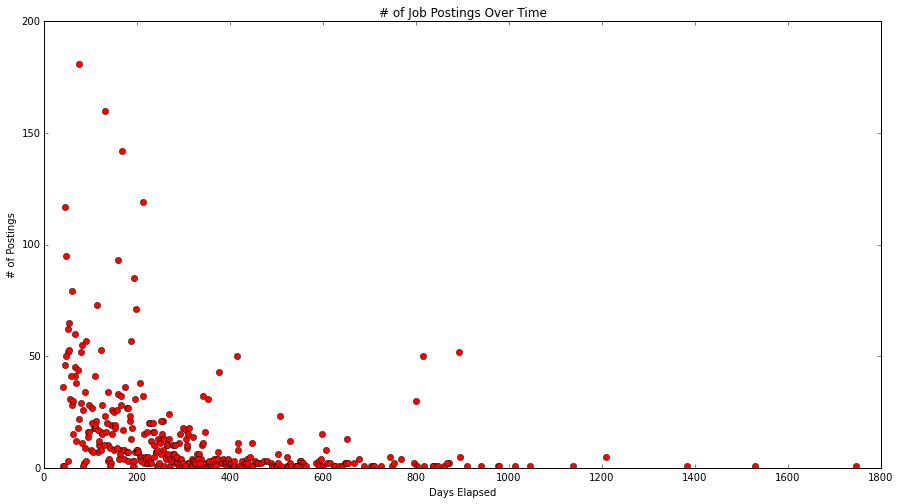

In [16]:
from collections import defaultdict
def jobs_over_time(dataframe):
    """ Returns a dictionary of points where key = Days Elapsed since Posting Date and value is the 
    total number of job postings that are that old.
    """
    jobs_by_age = defaultdict(int)
    for row in dataframe.itertuples():
        #row[3] is # Of Positions column
        #row[5] is Days Elapsed column
        jobs_by_age[row[5]] += row[3]
    return jobs_by_age

jobs_over_time_dict = jobs_over_time(oldest_jobs)
#print jobs_over_time_dict

%matplotlib inline
x = jobs_over_time_dict.keys()
y = jobs_over_time_dict.values()
plt.figure(figsize=(15,8))
plt.plot(x, y, 'ro')
plt.xlabel("Days Elapsed")
plt.ylabel("# of Postings")
plt.title("# of Job Postings Over Time")

So it looks like most jobs were posted between 200-400 days ago. And actually, the oldest listing is from 2011 (~1746 days ago)! The Department of Business Services may still be looking for that Account Manager, for all we know. It's possible that the agencies forgot to remove these jobs the database once they'd filled the positions. On the other hand, if these positions are actually still open, then this could be very meaningful data that supports the conclusion that these job positions are tough to fill. We can't confidently make a conclusion about whether or not these jobs are really hard to fill, or if the agencies simply forgot to remove these jobs from the database. 

However, we can try to glean from information from the data available to us. The rows with a high number of job openings and high number of days elapsed are with the NYC Housing Authority: Maintenance Worker, Temporary Painter, and Plasterer, each with 52, 50 and 30 job openings, respectively. These 3 jobs were also all posted at least 800 days ago. This leads me to suspect that these are the hardest jobs to fill.

## Summary

1. The Department of Health/Mental Hygiene has the most openings.
2. From our analysis of current job openings, even though the Office of Management and Budget technically offers the highest mean annual salary, since it only has one position open, it's not necessarily indicative of the agency's salaries as a whole. With 66 annually paid job openings, the Department of Sanitation seems to offer potential candidates the highest annual salaries. The Fire Department offers the highest hourly and daily salaries. The lowest annual salaries go to the Dept of Parks and Recreation. Though this agency is not the lowest on the list, it has the most openings, and is therefore more likely to be indicative of the agency's salaries as a whole when compared to other agencies with low salaries but also a small number of openings. The lowest hourly rate goes to the Office of Collective Bargaining, at \$9.50/hr. The Dept of Citywide Administrative Services offers the lowest daily pay rate.

3. It's tough to make any firm conclusions about which jobs are hardest to fill. I chose to narrow my focus on my first suspicion: that jobs that were posted a long time ago have remained vacant for a reason. These 3 jobs were not only posted a long time ago, but also have a high number of job openings: NYC Housing Authority: Maintenance Worker, Temporary Painter, and Plasterer. Since they meet two of my criteria, I am inclined to believe that these jobs are at least somewhat hard to fill.